In [3]:
# standard python imports
import random 
import copy
import math
import numpy as np
import time
import seaborn as sns
import dill
import matplotlib.pyplot as plt

In [4]:
# gridworld class that defines the state at an given instance

class gridworld:
    
    def __init__(self, gridsize, init, epsilon, discount_rate, lmda):
        
        """ class constructor to initialise the state of the gridworld """
        
        # ensure that gridsize is an integer
        if isinstance(gridsize, int) == False:
            
            raise ValueError("Grid size must be an integer")
        
        # ensure that gridsize must be greater or equals to 1
        elif gridsize <= 1:
            
            raise ValueError("Grid size must be greater than 1")
        
        else:
            
            # size of square gridworld
            self.gridsize = gridsize 
        
        # create empty board (indicated by "_")
        self.board = [['_' for x in range(self.gridsize)] for y in range (self.gridsize)]
        
        # number of holes rounded off to nearest integer
        self.no_of_holes = round(0.25 * self.gridsize * self.gridsize)
        
        # create empty list of hole positions
        self.holes = []
        
        # fill board with valid holes and update hole list
        self.add_valid_holes(init)
        
        # tuple that records position of robot
        self.robot_state = [0, 0]
        
        # update board with position of frisbee (indicated by 'f') and position of robot (indicated by 'r')
        self.board[0][0] = 'r'
        self.board[self.gridsize - 1][self.gridsize - 1] = 'f'
        
        # list of moves for the robot: up (index 0), down (index 1), left (index 2), right (index 3)
        self.moveset = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        # stores selected move (0 - 3)
        self.selected_move = None
        
        # stores time step, which increase incrementally by 1 after every action
        self.time_step = 0
        
        # log for robot state, action and reward. reward at time-step 0 is 0
        self.robot_state_log = []
        self.action_log = []
        self.reward_log = [0]
        
        # stores epsilon for epsilon greedy policy
        self.epsilon = epsilon
        
        # stores discount rate
        self.discount_rate = discount_rate
        
        # store lambda for eligiblity traces update (a form of decay rate)
        self.lmda = lmda  
        
        # stores q values. 1st and 2nd arguments represent i and j poistion (state) and 3rd agument represent action
        self.q_values = np.zeros((self.gridsize, self.gridsize, len(self.moveset)))
        
        # store array of returns for each state - action pair to record returns from all episodes for fv_mc_wo_es
        # to be initialised by first iteration of training
        self.all_ep_returns = None
        
        # binary true/false to show if robot is in terminal state due to being in hole or frisbee
        self.hole_terminal = False 
        self.frisbee_terminal = False
        
    def add_valid_holes(self, init):
        
        """ function to update empty hole list and board with valid holes """
        """ validity condition 1: holes do not fall in initial location of robot and location of frisbee """
        """ validity condition 2: holes do not completely block robots access from frisbee """
       
         # location of holes based on mode 
        if init == "manual":
            
            # ensure that gridsize == 4 according to basic implimentation
            if self.gridsize != 4:
                raise Exception("Size of grid must be 4 for manual implementation")
            
            # define holes according to basic implementation 
            self.holes = [[1, 1], [1, 3], [2, 3], [3, 0]]  
            
            # update board with holes
            for hole in self.holes:
                self.board[hole[0]][hole[1]] = 'h'
            
        elif init == "random":
            
            valid_cond_2 = False
            
            while valid_cond_2 == False:
                
                # initialise 2D list of size of board gridsize with 0
                paths = [[0 for x in range(self.gridsize)] for y in range (self.gridsize)]
                
                # initialise initial location of robot with 1
                paths[0][0] = 1
                
                # generate number of holes that fulfill validity condition 1
                for x in range(self.no_of_holes):

                    valid_cond_1 = False

                    while valid_cond_1 == False:
                        
                        try:
                            
                            # randomly generate i, j locations of holes within grid size
                            i_loc = random.randrange(0, self.gridsize)
                            j_loc = random.randrange(0, self.gridsize)

                            # raise exception if position is initial position of robot or location of frisbee
                            if i_loc == 0 and j_loc == 0 or i_loc == (self.gridsize - 1) and j_loc == (self.gridsize - 1):
                                raise Exception

                            # raise exception if position is already an existing hole
                            for hole in self.holes:
                                if i_loc == hole[0] and j_loc == hole[1]:
                                    raise Exception
                        
                        except Exception:
                            
                            pass
                        
                        else:
                            
                            # validity condition is satisified if code is else block is executed 
                            valid_cond_1 = True
                            
                            # append to list of holes
                            self.holes.append([i_loc, j_loc])

                            # update board with location of hole (indicated by "h")
                            self.board[i_loc][j_loc] = 'h'
                        
                # initializing first column and row of the 2D list
                for i in range(1, self.gridsize): 

                    # transverse down column. set value as 1 (no. of ways to travel to current location) if obstacle not found.
                    if self.board[i][0] != 'h': 
                        paths[i][0] = paths[i-1][0]
                    
                    # transverse down row. set value as 1 (no. of ways to travel to current location) if obstacle not found.
                    if self.board[0][i] != 'h': 
                        paths[0][i] = paths[0][i-1]
                
                # iterate for all selected cells 
                for i in range(1, self.gridsize): 
                    for j in range(1, self.gridsize): 

                        # If current cell is not obstacle, no. of ways to travel position (i, j) = no. of ways to travel to 
                        # position (i-1, j) + no. of ways to travel to position (i, j-1)
                        if self.board[i][j] != 'h': 
                            paths[i][j] = paths[i-1][j] + paths[i][j-1] 

                # bottom left value (frisbee location) shows number of ways to reach frisbee from robot initial location given 
                # current configurtion of holes.
                if paths[-1][-1] != 0:
                    
                    # ensure validity condition 2 is fulfilled
                    valid_cond_2 = True
                
                else:
                    
                    # Reset board and holes list to initial empty state
                    self.holes = []
                    self.board = [['_' for x in range(self.gridsize)] for y in range (self.gridsize)]
    
    def show_grid_state(self):
        
        """ fucntion to print out current gridworld state """
        
        # print current time step
        print(f'time step: {self.time_step}')
        
        # iterates over every grid in the board and print value on grid in a gridsize X gridsize manner 
        for x in range(self.gridsize):
            for y in range(self.gridsize):
                print(self.board[x][y], end = ' ')
            print("\t")
        print("\t")
    
    def is_move_valid(self):
        
        """ function to check if move is valid """
        
        # robot's current position
        i_initial = self.robot_state[0]
        j_initial = self.robot_state[1]

        # change in position from move
        i_change = self.moveset[self.selected_move][0]
        j_change = self.moveset[self.selected_move][1]

        # new position of robot
        i_new = i_initial + i_change
        j_new = j_initial + j_change

        # check if move is falls outside of the grid
        if i_new < 0 or i_new >= self.gridsize or j_new < 0 or j_new >= self.gridsize:
            
            # if yes return False
            return False
        
        else:
            
            # else return True
            return True

    def policy(self, mode): 
        
        """ function that selects optimal valid action for a given state from q values given mode (greedy or epsilon greedy) """
                
        # gives array with 4 q values (for each move) based on robot's current state
        q_values_for_state = self.q_values[self.robot_state[0]][self.robot_state[1]][:]
       
        # sort the arguments (moves) of q values in ascending order of q values
        # if more than one of same q value, larger index is placed higher in the sort
        sorted_q_values_index = np.argsort(q_values_for_state)
        
        # boolean to indicate if move is valid
        is_valid = False
        
        # count number of invalid actions 
        count_invalid = 0
        
        if mode == 'greedy':
            
            while is_valid == False:
                
                # initialise probabilities for each move to zero
                p_values = [0 for x in range(len(self.moveset) - count_invalid)]

                # initialise lowest possible value for q value
                max_q_value = -math.inf

                # intialise count for number of moves with max_q_value
                count_max = 0

                # iterate from end of array as array is sorted in ascending order
                for x in range(-1, -(len(self.moveset) - count_invalid + 1), -1):

                    # if current q value is greater or equal to current max q value
                    if q_values_for_state[sorted_q_values_index[x]] >= max_q_value:

                        # update max_q_value with larger value
                        max_q_value = q_values_for_state[sorted_q_values_index[x]] 

                        # increase count by 1
                        count_max += 1

                    # else break for loop
                    else:

                        break

                # update p values tables to select move with largest q value with equal probability (if multiple moves)
                for x in range(-1, -(count_max + 1), -1):
                    p_values[x] = 1 / count_max

                # select move greedily (based on probabilities assigned)
                self.selected_move = np.random.choice(sorted_q_values_index, p = p_values)
                
                # check if move is valid 
                is_valid = self.is_move_valid()
                
                # if move is invalid
                if is_valid == False:
                    
                    # remove move from sorted_q_values_index
                    sorted_q_values_index = np.delete(sorted_q_values_index, np.where(sorted_q_values_index == self.selected_move)[0][0])
                    
                    # increase invalid moves count by 1
                    count_invalid += 1
                
                # if move is valid 
                else:
                    
                    # change Boolean indicator to True
                    is_valid = True
                
        elif mode == 'egreedy':
            
            while is_valid == False:
            
                # assign probablity of epsilon / no. of possible actions to each action
                p_values = [self.epsilon / (len(self.moveset) - count_invalid) for x in range(len(self.moveset) - count_invalid)]

                # initialise lowest possible value for q value
                max_q_value = -math.inf

                # intialise count for number of moves with max_q_value
                count = 0

                # intialise list for index of moves with max_q_value from sorted_q_values_index
                max_q_index = []

                # iterate from end of array as array is sorted in ascending order
                for x in range(-1, -(len(self.moveset) - count_invalid + 1), -1):

                    # if current q value is greater or equal to current max q value
                    if q_values_for_state[sorted_q_values_index[x]] >= max_q_value:

                        # update max_q_value with larger value
                        max_q_value = q_values_for_state[sorted_q_values_index[x]]

                        # increase count by 1
                        count += 1

                        # append index to index list
                        max_q_index.append(x)

                    # else break for loop
                    else:

                        break    

                # select an index from max_q_index at random
                max_index = random.choice(max_q_index)

                # add remaining probability (1 - epsilon) to action with max q value using max index chosen, randomly (if multiple)
                p_values[max_index] = p_values[max_index] + 1 - self.epsilon

                # select move epsilon greedily (based on probabilities assigned)
                self.selected_move = np.random.choice(sorted_q_values_index, p = p_values)
                
                # check if move is valid 
                is_valid = self.is_move_valid()
                
                # if move is invalid
                if is_valid == False:
                    
                    # remove move from sorted_q_values_index
                    sorted_q_values_index = np.delete(sorted_q_values_index, np.where(sorted_q_values_index == self.selected_move)[0][0])
                    
                    # increase invalid moves count by 1
                    count_invalid += 1
                
                # if move is valid 
                else:
                    
                    # change Boolean indicator to True
                    is_valid = True
    
    def move(self, verbose):
        
        """ function that implements movement and update board and robot state given valid selected move """
                
        try:
            
            # robot's current position
            i_initial = self.robot_state[0]
            j_initial = self.robot_state[1]
    
            # change in position from move
            i_change = self.moveset[self.selected_move][0]
            j_change = self.moveset[self.selected_move][1]
            
            # new position of robot
            i_new = i_initial + i_change
            j_new = j_initial + j_change
            
    
            # check if robot reached a hole. if yes, no need to update robot state and board
            for hole in self.holes:
                if i_new == hole[0] and j_new == hole[1]:

                    # highlight end of session 
                    self.hole_terminal = True 
                        
                    # print event log for user when necessary (evaluating after training)
                    if verbose == True:
                        print(f"robot fell in hole at location {hole}. epsiode terminated")
                        print("\t")

                    raise Exception

            # check if robot reached the frisbee. if yes, no need to update robot state and board
            if i_new == (self.gridsize - 1) and j_new == (self.gridsize - 1):

                # highlight end of session 
                self.frisbee_terminal = True 

                # print event log for user when necessary (evaluating after training)
                if verbose == True:
                    print("robot reached the frisbee. epsiode terminated")
                    print("\t")

                raise Exception

        except Exception:

            pass

        else:
   
            # update robot's position
            self.robot_state[0] = i_new
            self.robot_state[1] = j_new

            # update board with new location of robot
            self.board[i_new][j_new] = 'r'
            self.board[i_initial][j_initial] = '_'

            # print event log for user when necessary (evaluating after training)
            if verbose == True:
                print(f'robot moved from ({i_initial}, {j_initial}) to ({i_new}, {j_new})')
                print("\t")
            
    
    def turn_log(self, mode, verbose):
        
        """ function that implement an turn"""
        """ turn: current state -> select action -> implement action -> reach next state -> obtain reward"""
        """ function also saves the state, action and reward for every timestep in the log """
        
        # save robot's current state in robot state log
        self.robot_state_log.append(copy.copy(self.robot_state))
        
        # implement policy
        self.policy(mode)
        
        # implements movement and update board and robot state given valid selected move
        self.move(verbose)
        
        # save action taken in action long
        self.action_log.append(self.selected_move)
        
        # increase time step by 1
        self.time_step += 1
        
        if self.hole_terminal == True:
            
            # if robot entered a hole, save reward of -1 in reward log
            self.reward_log.append(-1)
        
        elif self.frisbee_terminal == True:
            
            # if robot reached frisbee, save reward of 1 in reward log
            self.reward_log.append(1)
        
        else:
            
            # for all other cases, reward is 0
            self.reward_log.append(0)
            
    def turn_wo_log(self, mode, verbose):
        
        """ function that implement an turn"""
        """ turn: current state -> select action -> implement action -> reach next state -> obtain reward"""
        """ function returns reward """
        
        # implement policy
        self.policy(mode)
        
        # implements movement and update board and robot state given valid selected move
        self.move(verbose)
        
        # increase time step by 1
        self.time_step += 1
        
        if self.hole_terminal == True:
            
            # if robot entered a hole, save reward of -1 in reward log
            return -1
        
        elif self.frisbee_terminal == True:
            
            # if robot reached frisbee, save reward of 1 in reward log
            return 1
        
        else:
            
            # for all other cases, reward is 0
            return 0
    
    def reset(self):
        
        """ function that reset the gridworld after an episode """
        
        # update position of robot ('r') and remove replace previous robot state in board with empty space ("_")
        if self.robot_state[0] != 0 or self.robot_state[1] != 0:
            self.board[0][0] = 'r'
            self.board[self.robot_state[0]][self.robot_state[1]] = '_'
        
        # reset tuple that records position of robot
        self.robot_state = [0, 0]
        
        # reset time step, which increase incrementally by 1 after every action
        self.time_step = 0
        
        # reset log for robot state, action and reward. reward at time-step 0 is 0
        self.robot_state_log = []
        self.action_log = []
        self.reward_log = [0]
        
        # reset binary true/false to show if robot is in terminal state due to being in hole or frisbee
        self.hole_terminal = False 
        self.frisbee_terminal = False
    
    def fv_mc_wo_es(self, num_of_iter):
        
        """ this function implements first visit monte carlo without exploring starts """
        
        # loop over a number of iterations (theoretically infinite) 
        for x in range(num_of_iter):
    
            # generate an episode using following current epsilon greedy policy on current q-values
            while self.hole_terminal == False and self.frisbee_terminal == False:
                
                # run a turn epsilon greedily with log files to save the entire episode
                self.turn_log(mode = 'egreedy', verbose = False)
                
                # add timeout of 10000 time step should episode run for too long
                if self.time_step == 10000:
                    
                    # consider the timeout episode to be a failure
                    self.hole_terminal = True
            
            # store terminal time step
            time_step_terminal = self.time_step
            
            # stores returns from specific episode for each state - action pair 
            ep_returns = np.zeros((self.gridsize, self.gridsize, len(self.moveset), 1))
            
            # stores return with time step as index. return at terminal state (at terminal time step, T) is 0 by default
            ep_returns_ts = np.zeros((time_step_terminal + 1))
           
            # iterate from time step (ts) T-1 to time step 0
            for ts in reversed(range(time_step_terminal)):
              
                try: 

                    # load state from state log and action from action log for specific time step
                    i_ts = self.robot_state_log[ts][0]
                    j_ts = self.robot_state_log[ts][1]
                    action_ts = self.action_log[ts]
                    
                    # load reward from reward log from (specific time step + 1)
                    reward_ts_plus_1 = self.reward_log[ts + 1]
                    
                    # return at time step t = (reward at time step t+1) + (discount rate) * (return at time step t+1)
                    # G_t = R_t + y * G_(t+1) for 0 <= t < T , where T is the terminal time step
                    return_ts = reward_ts_plus_1 + self.discount_rate * ep_returns_ts[ts + 1]
                   
                    # update ep_returns_ts with the reward of this specific time step regardless
                    ep_returns_ts[ts] = return_ts
                    
                    # check previous states to ensure only first visit is recorded
                    for ts2 in range(ts):

                        # raise exception if earlier identical states is visited at earlier time step
                        if self.robot_state_log[ts2][0] == i_ts and self.robot_state_log[ts2][1] == j_ts:
                            raise Exception
                
                except Exception:
                    
                    pass
                
                else:
                    
                    # if it is first visit state - action pair in specific time step, append return to ep_returns
                    ep_returns[i_ts][j_ts][action_ts][0] = return_ts
            
            # if this is first iteration, deepcopy ep_returns as all_ep_returns that is initialised as None
            if x == 0:
                
                self.all_ep_returns = copy.deepcopy(ep_returns)
                
            # else concatenate ep_returns with all_ep_returns
            else:
                
                self.all_ep_returns = np.concatenate((self.all_ep_returns, ep_returns), axis = 3)
            
            
            # generate all_ep_returns array ignoring all zero values
            all_ep_returns_wo_zeros = np.ma.masked_equal(self.all_ep_returns, 0)
            
            # take the average of all_ep_returns to give new q values 
            self.q_values = np.array(np.mean(all_ep_returns_wo_zeros, axis = 3))
           
            # reset states and logs to initial state for new episode
            self.reset()
    
    def one_step_sarsa_qlearning(self, num_of_iter, algo):
        
        """ function implements one step sarsa or qlearning algorithm as per basic implementation """
        
        # iterate over num_of_iter of episodes
        for x in range(num_of_iter):
            
            # run an episode
            while self.hole_terminal == False and self.frisbee_terminal == False:
                
                # record robot state at current time step
                i_ts = self.robot_state[0]
                j_ts = self.robot_state[1]
                
                if self.time_step == 0:
                    
                    # implement egreedy policy to select an action at the start of the episode
                    self.policy(mode = 'egreedy')
        
                    # record selected action
                    action_ts = self.selected_move
                
                    # intialsie step size to be 1
                    step_size = 1
                
                else: 
                    
                    # record selected action from given state selected from policy at end of previous iteration
                    action_ts = self.selected_move 
                    
                    # intialsie step size to be 1 / timestep
                    step_size = 1 / self.time_step
        
                # implements movement and update board and robot state given valid selected move
                self.move(verbose = False)
                
                # record robot state at next time step
                i_ts_plus_1 = self.robot_state[0]
                j_ts_plus_1 = self.robot_state[1]
                
                # increase time step by 1
                self.time_step += 1
                
                if self.hole_terminal == True:

                    # if robot entered a hole, reward -1 
                    reward_ts_plus_1 = -1

                elif self.frisbee_terminal == True:

                    # if robot reached frisbee, save reward of 1 in reward log
                    reward_ts_plus_1 = 1

                else:

                    # for all other cases, reward is 0
                    reward_ts_plus_1 = 0
                
                if algo == 'sarsa':
                
                    # implement egreedy policy to select next action given new state at (time step + 1)
                    self.policy(mode = 'egreedy')

                    # record selected move at (time step + 1)
                    action_ts_plus_1 = self.selected_move

                    # perform sarsa q value update
                    # Q(S, A) = Q(S, A) + alpha * (R + Y * Q(S', A') + Q(S, A)), where S is state at time step t, S' is state at 
                    # time step (t + 1), A is action at time step t, A' is action at time step (t + 1), R is reward at time step
                    # (t+ 1) (after taking action A from state S), alpha is the step size, Y is discount rate
                    self.q_values[i_ts][j_ts][action_ts] = self.q_values[i_ts][j_ts][action_ts] + step_size * (reward_ts_plus_1 + self.discount_rate * self.q_values[i_ts_plus_1][j_ts_plus_1][action_ts_plus_1] - self.q_values[i_ts][j_ts][action_ts])
                
                elif algo == 'q_learning':
                    
                    # implement greedy policy to select next action given new state at (time step + 1)
                    self.policy(mode = 'greedy')
                    
                    # record selected move at (time step + 1)
                    action_ts_plus_1 = self.selected_move
                    
                    # perform qlearning q value update
                    # Q(S, A) = Q(S, A) + alpha * (R + Y * max(Q(S', A')) + Q(S, A)), where S is state at time step t, S' is 
                    # state at time step (t + 1), A is action at time step t, A' is action at time step (t + 1), R is reward at
                    # time step (t+ 1) (after taking action A from state S), alpha is the step size, Y is discount rate
                    self.q_values[i_ts][j_ts][action_ts] = self.q_values[i_ts][j_ts][action_ts] + step_size * (reward_ts_plus_1 + self.discount_rate * self.q_values[i_ts_plus_1][j_ts_plus_1][action_ts_plus_1] - self.q_values[i_ts][j_ts][action_ts])
                
                # add timeout of 10000 time step should episode run for too long
                if self.time_step == 10000:
                    
                    # consider the timeout episode to be a failure
                    self.hole_terminal = True
                
            # reset states to initial state for new episode
            self.reset()
            
    def sarsa_lamda(self, num_of_iter):
        
        """ additional implementation of sarsa lamda algorithm to investigate performance """
        """ online, backward view implementation using eligibilty traces """
        
        # iterate over num_of_iter of episodes
        for x in range(num_of_iter):
            
            # initialise eligibility trace to zero for all state-action pairs
            e_trace = np.zeros((self.gridsize, self.gridsize, len(self.moveset)))
            
            # run an episode
            while self.hole_terminal == False and self.frisbee_terminal == False:

                # record robot state at current time step
                i_ts = self.robot_state[0]
                j_ts = self.robot_state[1]

                if self.time_step == 0:

                    # implement egreedy policy to select an action at the start of the episode
                    self.policy(mode = 'egreedy')

                    # record selected action
                    action_ts = self.selected_move

                    # intialsie step size to be 1
                    step_size = 1

                else: 

                    # record selected action from given state selected from policy at end of previous iteration
                    action_ts = self.selected_move 

                    # intialsie step size to be 1 / timestep
                    step_size = 1 / self.time_step

                # implements movement and update board and robot state given valid selected move
                self.move(verbose = False)

                # record robot state at next time step
                i_ts_plus_1 = self.robot_state[0]
                j_ts_plus_1 = self.robot_state[1]

                # increase time step by 1
                self.time_step += 1

                if self.hole_terminal == True:

                    # if robot entered a hole, reward -1 
                    reward_ts_plus_1 = -1

                elif self.frisbee_terminal == True:

                    # if robot reached frisbee, save reward of 1 in reward log
                    reward_ts_plus_1 = 1

                else:

                    # for all other cases, reward is 0
                    reward_ts_plus_1 = 0

                # implement egreedy policy to select next action given new state at (time step + 1)
                self.policy(mode = 'egreedy')
                
                # record selected move at (time step + 1)
                action_ts_plus_1 = self.selected_move

                # update TD Error (delta_t)
                # delta_t = R_(t+1) + Y * Q_t(S_(t+1), A_(t+1)) - Q_t(S_t, A_t), where R_(t+1) is reward at time step t+1, Y is  
                # discount_rate, S_(t+1) is state at time step t+1, A_(t+1) is action at time step t+1, S_t is state at time 
                # step t A_t is action at time step t
                delta_t = reward_ts_plus_1 + self.discount_rate * self.q_values[i_ts_plus_1][j_ts_plus_1][action_ts_plus_1] - self.q_values[i_ts][j_ts][action_ts]

                # update eligibility traces using accumulating traces
                e_trace[i_ts][j_ts][action_ts] = e_trace[i_ts][j_ts][action_ts] + 1

                # update q values for every state-action pair 
                # Q_(t+1)(S, A) = Q_t(S, A) + alpha * delta_t * E_t(S, A), where S is state, A is action, alpha is 
                # step size and E is the eligbility trace array 
                self.q_values = self.q_values + step_size * delta_t * e_trace

                # update eligibility trace for every state-action pair 
                # E(S, A) = discount_rate * lambda * E(S, A), where S is state, A is action and lambda is decay rate 
                e_trace = self.discount_rate * self.lmda * e_trace
                
                # add timeout of 10000 time step should episode run for too long
                if self.time_step == 10000:
                    
                    # consider the timeout episode to be a failure
                    self.hole_terminal = True
                
            # reset states to initial state for new episode
            self.reset()

    def watkins_qlambda(self, num_of_iter):
        
        """ additional implementation of watkins q lamda algorithm to investigate performance """
        """ online, backward view implementation using eligibilty traces """
        
        # iterate over num_of_iter of episodes
        for x in range(num_of_iter):
            
            # initialise eligibility trace to zero for all state-action pairs
            e_trace = np.zeros((self.gridsize, self.gridsize, len(self.moveset)))
            
            # run an episode
            while self.hole_terminal == False and self.frisbee_terminal == False:

                # record robot state at current time step
                i_ts = self.robot_state[0]
                j_ts = self.robot_state[1]

                if self.time_step == 0:

                    # implement egreedy policy to select an action at the start of the episode
                    self.policy(mode = 'egreedy')

                    # record selected action
                    action_ts = self.selected_move

                    # intialsie step size to be 1
                    step_size = 1

                else: 

                    # record selected action from given state selected from policy at end of previous iteration
                    action_ts = self.selected_move 

                    # intialsie step size to be 1 / timestep
                    step_size = 1 / self.time_step

                # implements movement and update board and robot state given valid selected move
                self.move(verbose = False)

                # record robot state at next time step
                i_ts_plus_1 = self.robot_state[0]
                j_ts_plus_1 = self.robot_state[1]

                # increase time step by 1
                self.time_step += 1

                if self.hole_terminal == True:

                    # if robot entered a hole, reward -1 
                    reward_ts_plus_1 = -1

                elif self.frisbee_terminal == True:

                    # if robot reached frisbee, save reward of 1 in reward log
                    reward_ts_plus_1 = 1

                else:

                    # for all other cases, reward is 0
                    reward_ts_plus_1 = 0
                
                # implement greedy policy to select action that maximises q value
                self.policy(mode = 'greedy')
                
                # record selected maximising move at (time step + 1)
                action_ts_plus_1_max = self.selected_move
                
                # implement egreedy policy to select next action given new state at (time step + 1)
                self.policy(mode = 'egreedy')
                
                # record selected move at (time step + 1)
                action_ts_plus_1 = self.selected_move
                
                # update TD Error (delta_t)
                # delta_t = R_(t+1) + Y * Q_t(S_(t+1), A_(t+1)) - Q_t(S_t, A_t), where R_(t+1) is reward at time step t+1, Y is  
                # discount_rate, S_(t+1) is state at time step t+1, A_(t+1) is action at time step t+1, S_t is state at time 
                # step t A_t is action at time step t
                delta_t = reward_ts_plus_1 + self.discount_rate * self.q_values[i_ts_plus_1][j_ts_plus_1][action_ts_plus_1] - self.q_values[i_ts][j_ts][action_ts]
                
                # update eligibility traces using accumulating traces
                e_trace[i_ts][j_ts][action_ts] = e_trace[i_ts][j_ts][action_ts] + 1

                # update q values for every state-action pair 
                # Q_(t+1)(S, A) = Q_t(S, A) + alpha * delta_t * E_t(S, A), where S is state, A is action, alpha is 
                # step size and E is the eligbility trace array 
                self.q_values = self.q_values + step_size * delta_t * e_trace
                
                # initialise mask array of value zeros with same dimensions as e_trace array
                mask = np.zeros((self.gridsize, self.gridsize, len(self.moveset)))
                
                # only update state-action index with action index that corresponds to maximising move at (time step + 1) with 1
                mask[:][:][action_ts_plus_1_max] = 1

                # update eligibility trace only if selected action is maximising action (not exploratory)
                # E(S, A) = discount_rate * lambda * E(S, A), where S is state, A is action and lambda is decay rate 
                # if action is exploratory, set eligibility trace to 0 (using mask array)
                e_trace = self.discount_rate * self.lmda * e_trace * mask
                
                # add timeout of 10000 time step should episode run for too long
                if self.time_step == 10000:
                    
                    # consider the timeout episode to be a failure
                    self.hole_terminal = True
                
            # reset states to initial state for new episode
            self.reset()

In [5]:
def train_and_run_gridworld(gridsize, init, epsilon, discount_rate, lmda, num_of_iter, algo):
    
    """ function to initialise gridworld based of hyperparameter inputs, implement selected reinforcement algorithm """
    """ and implement an episode based on trained q values using greedy policy """
    """ function returns time taken to train algorithm and a binary to indicate success or failure in reaching frisbee"""
    """ success = reach frisbee, failure == reach hole or did not reach frisbee before episode timeout """
    
    # initialise gridworld with hyperparemeters
    game = gridworld(gridsize, init, epsilon, discount_rate, lmda)
    
    # implement first visit monte carlo without exploring starts
    if algo == 'fv_mc_wo_es':
        
        # record time at start of training
        t0 = time.time()
        
        # implement reinforcment learning for num_of_iter
        game.fv_mc_wo_es(num_of_iter)
        
        # record time at end of training
        t1 = time.time()
        
        # training time is the difference between end time and start time
        training_time = t1 - t0
    
    # implement one step sarsa or one step q learning 
    elif algo == 'sarsa' or algo == 'q_learning':
        
        # record time at start of training
        t0 = time.time()
        
        # implement reinforcment learning for num_of_iter
        game.one_step_sarsa_qlearning(num_of_iter, algo = algo)
        
        # record time at end of training
        t1 = time.time()
        
        # training time is the difference between end time and start time
        training_time = t1 - t0
    
    # implement sarsa lambda algorithm
    elif algo == 'sarsa_lambda':
        
        # record time at start of training
        t0 = time.time()
        
        # implement reinforcment learning for num_of_iter
        game.sarsa_lamda(num_of_iter)
        
        # record time at end of training
        t1 = time.time()
        
        # training time is the difference between end time and start time
        training_time = t1 - t0
    
    # implement q lambda algorithm
    elif algo == 'q_lambda':
        
        # record time at start of training
        t0 = time.time()
        
        # implement reinforcment learning for num_of_iter
        game.watkins_qlambda(num_of_iter)
        
        # record time at end of training
        t1 = time.time()
        
        # training time is the difference between end time and start time
        training_time = t1 - t0
    
    # implement an episode based on trained q values 
    while game.hole_terminal == False and game.frisbee_terminal == False:
        
        # implement a turn using greedy policy 
        game.turn_wo_log(mode = 'greedy', verbose = False)
        
        # if episode have not been terminated after 1000 time steps, terminate it
        if game.time_step == 1000:
            
            break;
    
    # returns 1 for success and training time
    if game.frisbee_terminal == True:
        
        return 1, training_time
    
    # return 0 and training time for failure
    else:
        
        return 0, training_time

In [56]:
def run_experiment_basic():
    
    # list of parameters values for training 
    epsilon_list = [round(0.1 + x * 0.05, 2) for x in range(5)]
    discount_rate_list = [x / 10 for x in range(5, 10)]
    lambda_list = [round(0.8 + x * 0.05, 2) for x in range(4)]
    num_of_iter_list = [x * 100 for x in range(1, 11)]
    algo_list = ['fv_mc_wo_es', 'sarsa', 'q_learning', 'sarsa_lambda', 'q_lambda']
    
    # 5D array for success and average training time to store results from training 
    success_count = np.zeros((len(epsilon_list), len(discount_rate_list), len(lambda_list), len(num_of_iter_list), len(algo_list)))
    time_avg = np.zeros((len(epsilon_list), len(discount_rate_list), len(lambda_list), len(num_of_iter_list), len(algo_list)))
    
    # iterate over every combination of parameters from parameters list
    for epsilon in epsilon_list:
        ind_epsilon = epsilon_list.index(epsilon)
        for discount_rate in discount_rate_list:
            ind_discount_rate = discount_rate_list.index(discount_rate)
            for lmda in lambda_list:
                ind_lmda = lambda_list.index(lmda)
                for num_of_iter in num_of_iter_list:
                    ind_num_of_iter = num_of_iter_list.index(num_of_iter)
                    for algo in algo_list:
                        ind_algo = algo_list.index(algo)
                        
                        # create time array to store time for repeated trials
                        time_1d = []
                        
                        # repeat trial for 5 times
                        for x in range(5):
                            
                            # train according to combination of parameters and obtain success/fail and training time 
                            is_success, time = train_and_run_gridworld(4, 'manual', epsilon, discount_rate, lmda, num_of_iter, algo)
                            
                            # append success/fail results to 5D success array
                            success_count[ind_epsilon][ind_discount_rate][ind_lmda][ind_num_of_iter][ind_algo] += is_success 
                            
                            # append training time to time array
                            time_1d.append(time)
                        
                        # find average time from 5 trials    
                        time_mean = sum(time_1d) / len(time_1d)
                        
                        # append average time to 5D average training time array
                        time_avg[ind_epsilon][ind_discount_rate][ind_lmda][ind_num_of_iter][ind_algo] = time_mean
    
    # take mean across epilson, discount rate and lambda parameters
    success_num_of_iter_vs_algo = np.mean(success_count, axis = (0, 1, 2))
    time_num_of_iter_vs_algo = np.mean(time_avg, axis = (0, 1, 2))
    
    # plot number of success for number of iterations vs algo
    plt.title("Number of success")
    ax1 = sns.heatmap(success_num_of_iter_vs_algo, xticklabels = algo_list, yticklabels = num_of_iter_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Number of iterations")
    plt.savefig("basic_success_num_of_iter_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # plot average training time for number of iterations vs algo
    plt.title("Average training time")
    ax2 = sns.heatmap(time_num_of_iter_vs_algo, xticklabels = algo_list, yticklabels = num_of_iter_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Number of iterations")
    plt.savefig("basic_time_num_of_iter_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # take mean across discount rate and lambda, number of iterations parameters
    success_epsilon_vs_algo = np.mean(success_count, axis = (1, 2, 3))
    time_epsilon_vs_algo = np.mean(time_avg, axis = (1, 2, 3))
    
    # plot number of success for epsilon vs algo
    plt.title("Number of success")
    ax3 = sns.heatmap(success_epsilon_vs_algo, xticklabels = algo_list, yticklabels = epsilon_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Epsilon")
    plt.savefig("basic_success_epsilon_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # plot average training time for epsilon vs algo
    plt.title("Average training time")
    ax4 = sns.heatmap(time_epsilon_vs_algo, xticklabels = algo_list, yticklabels = epsilon_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Epsilon")
    plt.savefig("basic_time_epsilon_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # take mean across epilson, lambda, number of iterations parameters
    success_discount_rate_vs_algo = np.mean(success_count, axis = (0, 2, 3))
    time_discount_rate_vs_algo = np.mean(time_avg, axis = (0, 2, 3))
    
    # plot number of success for discount rate vs algo
    plt.title("Number of success")
    ax5 = sns.heatmap(success_discount_rate_vs_algo, xticklabels = algo_list, yticklabels = discount_rate_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Discount Rate")
    plt.savefig("basic_success_discount_rate_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # plot average training time for discount rate vs algo
    plt.title("Average training time")
    ax6 = sns.heatmap(time_discount_rate_vs_algo, xticklabels = algo_list, yticklabels = discount_rate_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Discount Rate")
    plt.savefig("basic_time_discount_rate_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # take mean across epilson, discount rate, number of iterations parameters
    success_lambda_vs_algo = np.mean(success_count, axis = (0, 1, 3))
    time_lambda_vs_algo = np.mean(time_avg, axis = (0, 1, 3))
    
    # plot number of success for lambda vs algo
    plt.title("Number of success")
    ax7 = sns.heatmap(success_lambda_vs_algo, xticklabels = algo_list, yticklabels = lambda_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Lambda")
    plt.savefig("basic_success_lambda_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # plot average training time for lambda vs algo
    plt.title("Average training time")
    ax8 = sns.heatmap(time_lambda_vs_algo, xticklabels = algo_list, yticklabels = lambda_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Lambda")
    plt.savefig("basic_time_lambda_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    return success_count, time_avg

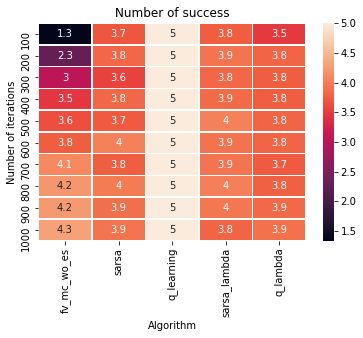

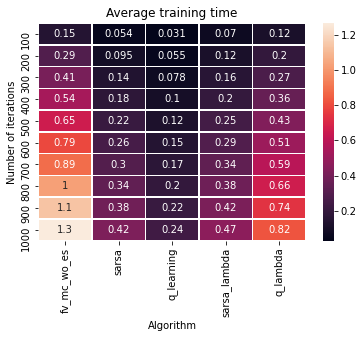

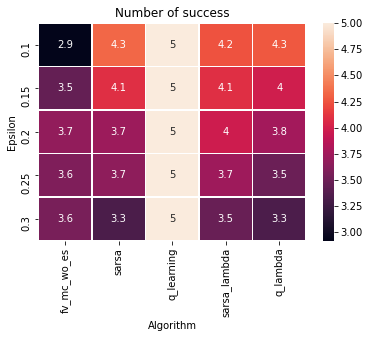

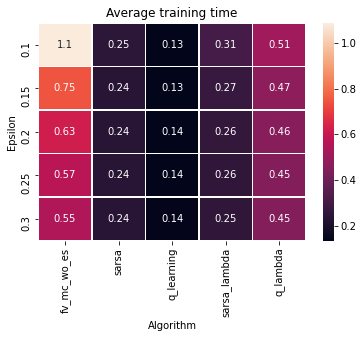

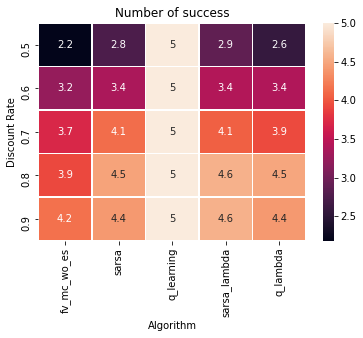

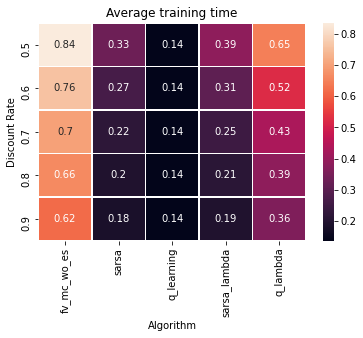

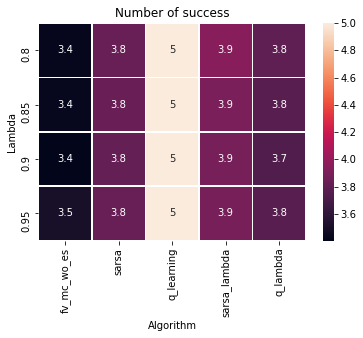

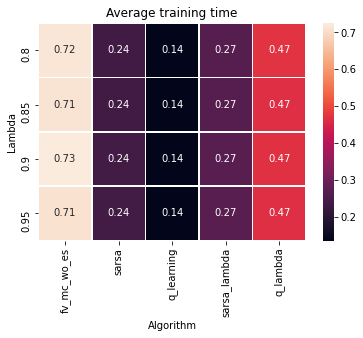

<Figure size 432x288 with 0 Axes>

In [39]:
success_count_basic, time_avg_basic = run_experiment_basic()

In [6]:
def run_experiment_extended():
    
    # list of parameters values for training 
    num_of_iter_list = [x * 1000 for x in range(1, 11)]
    algo_list = ['fv_mc_wo_es', 'sarsa', 'q_learning', 'sarsa_lambda', 'q_lambda']
    
    # 3D array for success and average training time to store results from training
    success_count = np.zeros((len(gridsize_list), len(num_of_iter_list), len(algo_list)))
    time_avg = np.zeros((len(gridsize_list), len(num_of_iter_list), len(algo_list)))
    
    # iterate over every combination of parameters from parameters list
    for num_of_iter in num_of_iter_list:
        print(f'num_of_iter: {num_of_iter}')
        ind_num_of_iter = num_of_iter_list.index(num_of_iter)
        for algo in algo_list:
            print(f'algo: {algo}')
            ind_algo = algo_list.index(algo)

            # create time array to store time for repeated trials
            time_1d = []

            # repeat trial for 5 times
            for x in range(5):

                # train according to combination of parameters and obtain success/fail and training time 
                is_success, time = train_and_run_gridworld(gridsize, 'random', 0.1, 0.9, 0.9, num_of_iter, algo)
                print(f'time {x}: {time}')

                # append success/fail results to 3D success array
                success_count[ind_gridsize][ind_num_of_iter][ind_algo] += is_success 

                # append training time to time array
                time_1d.append(time)

            # find average time from 5 trials 
            time_mean = sum(time_1d) / len(time_1d)

            # append average time to 3D average training time array
            time_avg[ind_gridsize][ind_num_of_iter][ind_algo] = time_mean
    
    success_num_of_iter_vs_algo = success_count
    time_num_of_iter_vs_algo = time_avg
    
    # plot number of success for number of iterations vs algo
    plt.title("Number of success")
    ax1 = sns.heatmap(success_num_of_iter_vs_algo, xticklabels = algo_list, yticklabels = num_of_iter_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Number of iterations")
    plt.savefig("extended_success_num_of_iter_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    # plot average training time for number of iterations vs algo
    plt.title("Average training time")
    ax2 = sns.heatmap(time_num_of_iter_vs_algo, xticklabels = algo_list, yticklabels = num_of_iter_list, annot=True, linewidths=.5)
    plt.xlabel("Algorithm")
    plt.ylabel("Number of iterations")
    plt.savefig("extended_time_num_of_iter_vs_algo.png", bbox_inches = 'tight')
    plt.show()
    
    return success_count, time_avg

num_of_iter: 1000
algo: fv_mc_wo_es
time 0: 374.8332345485687
time 1: 20.068644285202026
time 2: 7.1166064739227295
time 3: 71.4066412448883
time 4: 6.73626184463501
algo: sarsa
time 0: 33.10921335220337
time 1: 39.16316843032837
time 2: 7.4114556312561035
time 3: 7.957264184951782
time 4: 11.889801502227783
algo: q_learning
time 0: 1.0630147457122803
time 1: 1.0874526500701904
time 2: 1.1247508525848389
time 3: 1.2598955631256104
time 4: 0.910015344619751
algo: sarsa_lambda
time 0: 62.07150673866272
time 1: 24.389631271362305
time 2: 8.458091974258423
time 3: 44.415504932403564
time 4: 19.592622995376587
algo: q_lambda
time 0: 23.529380321502686
time 1: 337.7971158027649
time 2: 253.2658679485321
time 3: 36.03977942466736
time 4: 696.6828465461731
num_of_iter: 2000
algo: fv_mc_wo_es
time 0: 59.2055344581604
time 1: 166.82441663742065
time 2: 19.58613133430481
time 3: 35.541391134262085
time 4: 20.29241371154785
algo: sarsa
time 0: 253.9899401664734
time 1: 12.156258583068848
time 2: 1

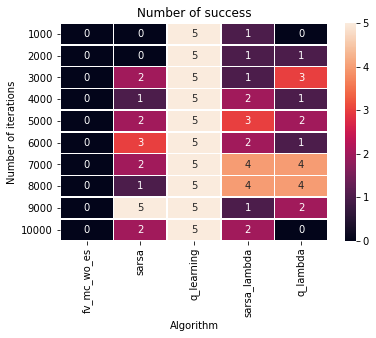

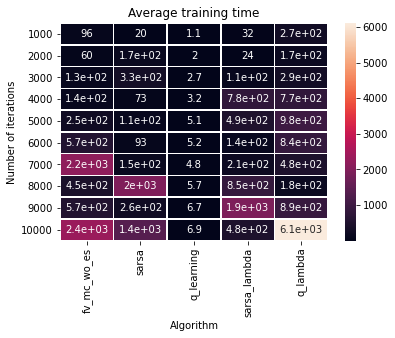

In [7]:
success_count_extended, time_avg_extended = run_experiment_extended()

In [8]:
dill.dump_session('gridworld.db')

In [2]:
dill.load_session('gridworld.db')